In [19]:
from pathlib import Path
import copy
from tqdm import tqdm
from itertools import product

import torch
import pyscf
import numpy as np
import opt_einsum as oe
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol
from cadft.utils import gen_basis


rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)
rc("font", family="serif")

rcParams["text.latex.preamble"] = thesis_latex

fontsize = 10.045
sca_size = 2
plt.rc("font", size=fontsize)  # controls default text size
plt.rc("axes", titlesize=fontsize)  # fontsize of the title
plt.rc("axes", labelsize=fontsize - 1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=fontsize - 2)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=fontsize - 2)  # fontsize of the y tick labels
plt.rc("legend", fontsize=fontsize)  # fontsize of the legend

plt.rcParams["figure.figsize"] = np.array([0.95, 0.5]) * 520 / 72

rcParams["axes.linewidth"] = 1.5
rcParams["lines.linewidth"] = 1.5
rcParams["xtick.major.width"] = 3
rcParams["xtick.minor.size"] = 5
rcParams["xtick.major.size"] = 5
rcParams["ytick.minor.size"] = 5
rcParams["ytick.major.size"] = 5
rcParams["xtick.minor.width"] = 1.5
rcParams["xtick.major.width"] = 1.5
rcParams["ytick.minor.width"] = 1.5
rcParams["ytick.major.width"] = 1.5

# mol_list = ["methyl-openshell"]
mol_list = ["methane"]
# mol_list = ["ethane", "acetylene"]

distance_list = [-0.5]

ang_to_au = 1 / 0.52917721067

System: uname_result(system='Linux', node='dhem-aorus15gxc', release='6.6.47-1-lts', version='#1 SMP PREEMPT_DYNAMIC Mon, 19 Aug 2024 05:13:57 +0000', machine='x86_64')  Threads 8
Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
numpy 1.26.4  scipy 1.14.0
Date: Thu Aug 29 15:17:27 2024
PySCF version 2.5.0
PySCF path  /home/dhem/anaconda3/envs/pyscf/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 5
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 C     -0.125650634761  -0.000001687045  -0.000003342079 AA   -0.237445287077  -0.000003188054  -0.000006315614 Bohr   0.0
[INPUT]  2 H      0.928463455311   0.068824876126   0.938668916653 AA    1.75454164

[['C', -0.1256506347613527, -1.6870454846820952e-06, -3.3420787922601195e-06], ['H', 0.928463455311382, 0.06882487612648398, 0.9386689166526917], ['H', 1.0576289356550572, 0.15282468499514204, -0.8382306192799442], ['H', -0.4038790555915889, 0.7660933589544437, -0.020336967842060828], ['H', -0.08491587280782514, -0.9877228166446128, -0.08006150413621219]]
number of ele 9.999983967019727
538


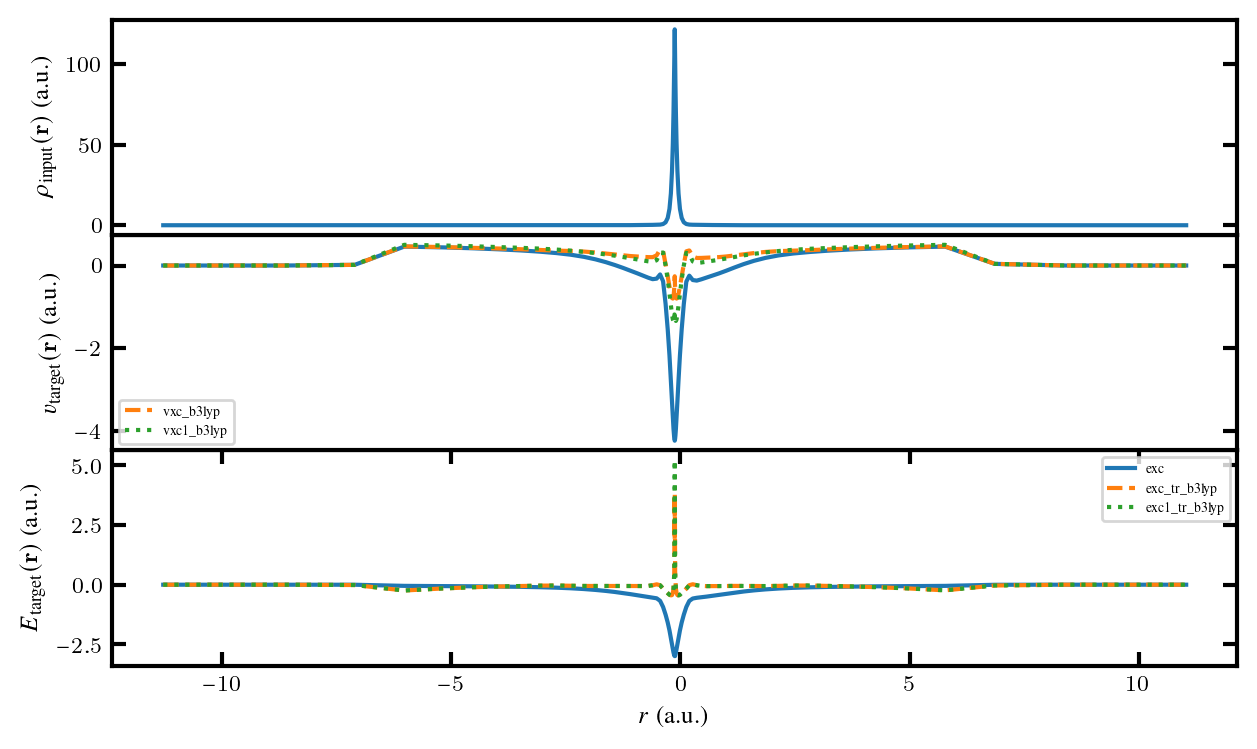

<Figure size 686.111x361.111 with 0 Axes>

In [25]:
for mol, distance in product(mol_list, distance_list):
    molecular = copy.deepcopy(Mol[mol])
    molecular[0][1] += distance

    dft2cc = CC_DFT_DATA(
        molecular,
        name="test",
        basis="STO-3G",
        if_basis_str=True,
        # spin=1,
    )

    grids = Grid(dft2cc.mol, level=1)
    coords = grids.coords

    data_path = f"../data/grids_mrks/data_{mol}_cc-pCVTZ_0-1_1_{distance:.4f}.npz"

    # print create time of data_path

    data = np.load(data_path)
    # data = np.load(
    #     "../data/grids_mrks_CVTZ_1/data/data_methane_cc-pCVTZ_0_1_-0.5000_bk.npz"
    # )

    exc_real = data["exc_real"]
    exc1_tr = data["exc1_tr"]
    # exc1_tr_b3lyp = data["exc1_tr_b3lyp"]
    exc_tr_b3lyp = data["exc_tr_b3lyp"]
    exc1_tr_b3lyp = data["exc1_tr_b3lyp"]
    vxc = data["vxc"]
    vxc_b3lyp = data["vxc_b3lyp"]
    vxc1_b3lyp = data["vxc1_b3lyp"]
    rho_cc = data["rho_cc"]
    # rho_inv_4 = data["rho_inv_4"]
    weights_grids = data["weights"]

    print("number of ele", np.sum(rho_cc * weights_grids))

    index_ = np.where(
        (np.abs(coords[:, 1]) < 1e-4)
        & (np.abs(coords[:, 2]) < 1e-4)
    )
    sort_ = np.argsort(coords[:, 0][index_])
    x = coords[:, 0][index_][sort_] / ang_to_au
    r_vec = np.linalg.norm(grids.coords[index_][sort_], axis=1)
    r_cut_off = 1 / (1 + np.exp(1 * (r_vec - 10)))
    y11 = (grids.matrix_to_vector(exc_real))[index_][sort_]
    y12 = (grids.matrix_to_vector(exc_tr_b3lyp))[index_][sort_]
    y13 = (grids.matrix_to_vector(exc1_tr_b3lyp))[index_][sort_]
    y21 = (grids.matrix_to_vector(vxc))[index_][sort_]
    y22 = (grids.matrix_to_vector(vxc_b3lyp))[index_][sort_]
    y23 = (grids.matrix_to_vector(vxc1_b3lyp))[index_][sort_]
    y31 = (grids.matrix_to_vector(rho_cc))[index_][sort_]
    # y32 = (grids.matrix_to_vector(rho_inv_4[0,:,:,:]))[index_][sort_]
    # y33 = (grids.matrix_to_vector(rho_inv_4[1,:,:,:]))[index_][sort_]
    # y34 = (grids.matrix_to_vector(rho_inv_4[2,:,:,:]))[index_][sort_]
    # y35 = (grids.matrix_to_vector(rho_inv_4[3,:,:,:]))[index_][sort_]

    f, axes = plt.subplots(3, 1)
    axes = axes.reshape(3, 1)

    begin_y = 0.1
    end_y = 0.995
    int_y = 0.0
    begin_x = 0.175
    end_x = 0.995
    int_x = 0.0
    end_x += int_x
    end_y += int_y

    shapexy = np.shape(axes)
    inter_x = np.linspace(begin_x, end_x, shapexy[1] + 1)
    inter_y = np.linspace(begin_y, end_y, shapexy[0] + 1)

    delta_x = inter_x[1] - inter_x[0] - int_x
    delta_y = inter_y[1] - inter_y[0] - int_y

    for i in range(shapexy[0]):
        for j in range(shapexy[1]):
            axes[i][j].set_position(
                [
                    inter_x[j],
                    inter_y[i],
                    inter_x[j + 1] - inter_x[j] - int_x,
                    inter_y[i + 1] - inter_y[i] - int_y,
                ]
            )
            axes[i][j].xaxis.set_tick_params(
                direction="in", which="both", bottom=True, top=True
            )
            axes[i][j].yaxis.set_tick_params(
                direction="in", which="both", left=True, right=True
            )

    axes = axes[::-1, :]

    axes[0, 0].plot(x, y31)
    # axes[0, 0].plot(x, y32, "--")
    # axes[0, 0].plot(x, y33, "-.")
    # axes[0, 0].plot(x, y34, ":")

    axes[1, 0].plot(x, y21)
    axes[1, 0].plot(x, y22, "--", label="vxc_b3lyp")
    axes[1, 0].plot(x, y23, ":", label="vxc1_b3lyp")

    axes[2, 0].plot(x, y11, label="exc")
    axes[2, 0].plot(x, y12, "--", label="exc_tr_b3lyp")
    axes[2, 0].plot(x, y13, ":", label="exc1_tr_b3lyp")

    # axes[0, 0].set_xlim(-0.5, 0.5)
    # axes[1, 0].set_xlim(-0.5, 0.5)
    # axes[2, 0].set_xlim(-0.5, 0.5)

    axes[0, 0].set_ylabel(r"$\rho_{\textrm{input}}(\bm{\mathrm{r}})$ (a.u.)")
    axes[1, 0].set_ylabel(r"$v_{\textrm{target}}(\bm{\mathrm{r}})$ (a.u.)")
    axes[2, 0].set_ylabel(r"$E_{\textrm{target}}(\bm{\mathrm{r}})$ (a.u.)")

    axes[0, 0].set_xticks([])
    axes[1, 0].set_xticks([])
    axes[2, 0].set_xlabel(r"$r$ (a.u.)")

    print(len(x))
    # plt.savefig(f"../manu/figures/{mol}_cc-pCVTZ_0_1_{distance:.4f}.pdf")
    axes[1, 0].legend(loc="best", fontsize=fontsize // 2)
    axes[2, 0].legend(loc="best", fontsize=fontsize // 2)

    # axes[0, 0].set_ylim(-1e-1, 1e-1)
    # axes[2, 0].set_ylim(-1e-1, 1e-1)
    # for i in range(shapexy[0]):
    #     for j in range(shapexy[1]):
    #         axes[i][j].set_xlim(-1.5, 1.5)
    plt.show()
    plt.clf()

In [ ]:
index_ = np.where((np.abs(coords[:, 2]) < 1e-10))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y = coords[:, 1][index_][sort_]
# z11 = (grids.matrix_to_vector(exc))[index_][sort_]
z12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
# z2 = (grids.matrix_to_vector(vxc))[index_][sort_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
# ax.plot_trisurf(x, y, z11, label="exc")
ax.plot_trisurf(x, y, z12, label="exc_real")
# ax.plot_trisurf(x, y, z2, label="vxc")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [ ]:
import torch

torch.cuda.mem_get_info()[0] // 8 // 140**4

In [ ]:
for hash_char in ["0", "1"]:
    print("1_1".startswith(f"{hash_char}_"))

In [ ]:
x = np.linspace(-10, 10, 1000)
# plt.plot(x, 1 / (1 + np.exp(-100 * (x-1))))
plt.plot(x, 1/ (1 + np.exp(100 * (x-5))))

In [ ]:
1.732 / 2